# Image Classification with CNN using Keras

# Task 1: Import Libraries

In [1]:
import tensorflow as tf
import os
import numpy as np

from matplotlib import pyplot as plt
%matplotlib inline

if not os.path.isdir('models'):
    os.mkdir('models')
    
print('TensorFlow version:', tf.__version__)
print('Is using GPU?', tf.test.is_gpu_available())

TensorFlow version: 2.1.0
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
Is using GPU? False


# Task 2: Preprocess Data

In [2]:
def get_two_classes(x, y):
    #cats has y==3, while dogs y==5 acording to cifar10 dataset.
    indices_0, _ = np.where(y == 3.)
    indices_1, _ = np.where(y == 5.)
    
    indices = np.concatenate([indices_0, indices_1], axis=0)
    
    indices = np.random.choice(indices, indices.shape[0], replace=False)
    
    x = x[indices]
    y = y[indices]
    
    y = tf.keras.utils.to_categorical(y)[:,[3,5]]
    
    return x, y

In [3]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
x_train, y_train = get_two_classes(x_train, y_train)
x_test, y_test = get_two_classes(x_test, y_test)

print(y_train.size)
print(y_test.size)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

20000
4000
(10000, 32, 32, 3) (10000, 2)
(2000, 32, 32, 3) (2000, 2)


# Task 3: Visualize Examples

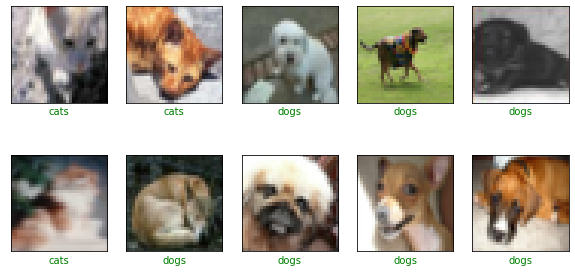

In [4]:
class_names = ['cats', 'dogs']

def show_random_examples(x, y, p):
    
    indicies = np.random.choice(range(x.shape[0]), 10, replace=False)
    
    x = x[indicies]
    y = y[indicies]
    p = p[indicies]
    
    plt.figure(figsize=(10, 5))
    for i in range(10):
        plt.subplot(2, 5, 1 + i)
        plt.imshow(x[i])
        plt.xticks([])
        plt.yticks([])
        col = 'green' if np.argmax(y[i]) == np.argmax(p[i]) else 'red'
        plt.xlabel(class_names[np.argmax(p[i])], color=col)
    plt.show()

show_random_examples(x_train, y_train, y_train)

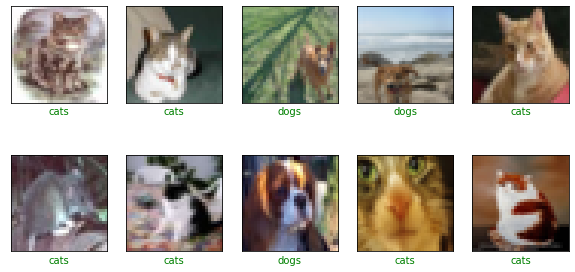

In [5]:
show_random_examples(x_train, y_train, y_train)

# Task 4: Create Model

In [6]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.layers import Dropout, Flatten, Input, Dense

def create_model():
    def add_conv_block(model, num_filters):
        model.add(Conv2D(num_filters, 3, activation='relu', padding='same'))
        model.add(BatchNormalization())
        model.add(Conv2D(num_filters, 3, activation='relu'))
        model.add(MaxPooling2D(pool_size=2))
        model.add(Dropout(0.5))
        return model
    
    model = tf.keras.models.Sequential()
    model.add(Input(shape=(32, 32, 3)))
    
    model = add_conv_block(model, 32)
    model = add_conv_block(model, 64)
    model = add_conv_block(model, 128)

    model.add(Flatten())
    model.add(Dense(2, activation='softmax'))
    
    model.compile(
        loss='categorical_crossentropy',
        optimizer='adam', metrics=['accuracy']
    )
    return model
model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 15, 15, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 15, 15, 64)        2

# Task 5: Train the Model

In [7]:
h = model.fit(
    x_train/255., y_train,
    validation_data=(x_test/255., y_test),
    epochs=1, batch_size=32,
    # batch_size=32
    # the experiments need more rigorous hyperparameter tunning, and due to procesing power limitation, I setteled for 
    # batch size 32.
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2),
        tf.keras.callbacks.ModelCheckpoint(
            'models/model_{val_accuracy:.3f}.h5',
            save_best_only=True, save_weights_only=False,
            monitor='val_accuracy'
        )
    ]
)

Train on 10000 samples, validate on 2000 samples
10000/10000 [==============================] - 74s 7ms/sample - loss: 0.8662 - accuracy: 0.5618 - val_loss: 0.6883 - val_accuracy: 0.5600


# Task 6: Final Predictions

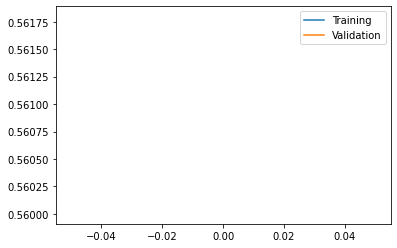

In [8]:
%matplotlib inline
losses = h.history['loss']
accs = h.history['accuracy']
val_losses = h.history['val_loss']
val_accs = h.history['val_accuracy']
epochs = len(losses)

plt.plot(range(len(accs)), accs, label='Training')
plt.plot(range(len(accs)), val_accs, label='Validation')
plt.legend()
plt.show()

In [9]:
model = tf.keras.models.load_model('models/model_0.719.h5')

In [10]:
preds = model.predict(x_test/255.)

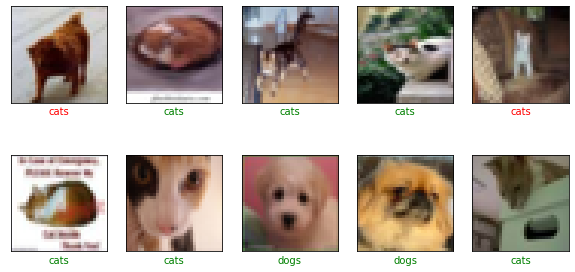

In [11]:
show_random_examples(x_test, y_test, preds)